# Infrared-Based Pressure Map Estimation for Pressure Ulcer Prevention

This work focuses on developing an artificial intelligence-based system to estimate pressure maps from infrared images, aiming to prevent the onset of pressure ulcers in patients who remain bedridden for extended periods. By transforming IR images into accurate pressure maps using a U-Net network, the goal is to identify early the critical areas where the body's weight is concentrated, thereby allowing timely interventions to avoid these injuries. This approach offers a cost-effective and efficient alternative to traditional methods, contributing to improved monitoring and care in hospital settings.

### IMPORTS:

First and foremost, I `import` all the libraries and modules required for my work and for creating my functions. This step involves including essential packages for data manipulation, mathematical computations, and any other functionalities that my code may depend on. By setting up these imports at the beginning, I ensure that all dependencies are readily available throughout the development process, thereby facilitating efficient coding and debugging.

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from scipy.ndimage import median_filter
import re
import matplotlib.pyplot as plt

### DATASET: DANALABDATASET

This section of the code is responsible for preparing and loading the dataset used in the project. The helper function `to_float32_and_scale` converts input tensors to 32-bit floating point format and normalizes them into the [0, 1] range based on provided global minimum and maximum values. The `DanaLabDataset` class, which inherits from PyTorch's Dataset, systematically navigates a directory structure containing patient data to find and pair infrared (IR) images with their corresponding pressure maps (PM). In its initialization, the class searches through specified subdirectories (e.g., "cover1", "cover2", "uncover") for the required images, and stores these pairs for later retrieval. The `__getitem__` method then handles loading each image pair in grayscale, optionally displaying them for debugging, and applies any defined image transformations (or defaults to a simple tensor conversion). This structure ensures that the dataset is efficiently prepared for subsequent training and evaluation stages in the model pipeline.

In [3]:
def to_float32_and_scale(tensor, global_min, global_max):
    """
    Function for normalize a tensor between [0, 1] range 
    given its global max and min values.ç
    """
    tensor = tensor.float()
    return (tensor - global_min) / (global_max - global_min + 1e-8)

class DanaLabDataset(Dataset):
    def __init__(self, 
                 root_dir, 
                 conditions=('cover1', 'cover2', 'uncover'),
                 transform_ir=True,
                 transform_pm=True,
                 show_debug=True):
        """
        root_dir: Base directory containing each patient's folders.  
        conditions: Conditions (subdirectories) where IR/PM images are searched for.  
        transform_ir: Transformations for the IR image.  
        transform_pm: Transformations for the pressure map (PM) image.  
        show_debug: If True, displays intermediate images for debugging.
        """
        self.root_dir = root_dir
        self.conditions = conditions
        self.transform_ir = transform_ir
        self.transform_pm = transform_pm
        self.show_debug = show_debug

        # List of pairs (IR_path, PM_path)
        self.pairs = []
        
        # Iterate through each patient
        for patient in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient)
            if not os.path.isdir(patient_path):
                continue

            # Expected IR and PM directories
            ir_folder = os.path.join(patient_path, 'IR')
            pm_folder = os.path.join(patient_path, 'PM')
            if not (os.path.isdir(ir_folder) and os.path.isdir(pm_folder)):
                continue

            # Iterate through the conditions (cover1, cover2, uncover, etc.)
            for cond in conditions:
                ir_cond_path = os.path.join(ir_folder, cond)
                pm_cond_path = os.path.join(pm_folder, cond)
                if not (os.path.isdir(ir_cond_path) and os.path.isdir(pm_cond_path)):
                    continue

                # List of files IR and PM
                ir_files = sorted(os.listdir(ir_cond_path))
                pm_files = sorted(os.listdir(pm_cond_path))

                # Pair each IR file with its corresponding PM
                for ir_file, pm_file in zip(ir_files, pm_files):
                    ir_full_path = os.path.join(ir_cond_path, ir_file)
                    pm_full_path = os.path.join(pm_cond_path, pm_file)
                    self.pairs.append((ir_full_path, pm_full_path))

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        ir_path, pm_path = self.pairs[idx]

        # Load in grayscale
        try:
            ir_img = Image.open(ir_path).convert('L')
            pm_img = Image.open(pm_path).convert('L')
        except Exception as e:
            print(f'Error al abrir la imagen {ir_path} o {pm_path}: {e}')
            return torch.zeros(1, 192, 84), torch.zeros(1, 192, 84)

        # Debug: Show the original images and their paths
        if self.show_debug:
            print(f"IR: {ir_path}")
            print(f"PM: {pm_path}")
            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.imshow(ir_img, cmap='gray')
            plt.title("IR Original")
            plt.subplot(1,2,2)
            plt.imshow(pm_img, cmap='gray')
            plt.title("PM Original")
            plt.show()

        # Apply defined transformations
        if self.transform_ir:
            ir_tensor = self.transform_ir(ir_img)
        else:
            ir_tensor = transforms.ToTensor()(ir_img)

        if self.transform_pm:
            pm_tensor = self.transform_pm(pm_img)
        else:
            pm_tensor = transforms.ToTensor()(pm_img)

        return ir_tensor, pm_tensor

### U-NET MODEL

This code implements the original U-Net architecture. It defines a `DoubleConv` module, which consists of two convolutional layers with batch normalization and ReLU activations, serving as the building block. The `UNET` class uses these blocks in an encoder-decoder structure with skip connections to preserve spatial details. Finally, a 1×1 convolution maps the features to the output channels, and a helper method allows freezing all layers except the final one for fine-tuning.

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

    def freeze_except_final(self):
        for param in self.parameters():
            param.requires_grad = False
        for param in self.final_conv.parameters():
            param.requires_grad = True

### LOSS FUNCTIONS

The `MSE loss` computes the average squared difference between the predicted and target values, providing a basic measure of overall error. The `WeightedPixelLoss` custom loss, on the other hand, assigns more importance to pixels with higher target values by creating a weight map. This means that errors in more critical areas (where the target values are higher) are penalized more.
*I will use the mse_loss function for now*

In [5]:
mse_loss = nn.MSELoss()

class WeightedPixelLoss(nn.Module):
    def __init__(self):
        super(WeightedPixelLoss, self).__init__()
    def forward(self, input_tensor, target_tensor):
        # Assign weights according to the magnitude of the target
        min_w, max_w = 1, 10
        scale = max_w - min_w
        # Avoid division by zero
        t_min, t_max = target_tensor.min(), target_tensor.max()
        denom = (t_max - t_min) if (t_max - t_min) != 0 else 1
        weight_map = ((target_tensor - t_min)/denom)*scale + min_w
        squared_diff = (input_tensor - target_tensor)**2
        loss = (weight_map*squared_diff).mean()
        return loss
weighted_loss = WeightedPixelLoss()

### TRAINING AND VALIDATION

The `train_one_epoch` function trains the model for one complete pass over the training data. It processes each batch by moving the inputs to the desired device, calculating predictions, computing the loss, backpropagating errors, and updating the model parameters with the optimizer. It also tracks and returns the average loss over the epoch.

The `validate` function, on the other hand, evaluates the model on a validation set. It sets the model to evaluation mode and computes the loss for each batch without updating any parameters, returning the average validation loss.

In [ ]:
def training(model, dataloader, optimizer, loss_fn, device="cpu"):
    model.train()
    running_loss = 0.0

    for batch_idx, (ir_imgs, pm_imgs) in enumerate(dataloader):
        ir_imgs = ir_imgs.to(device)
        pm_imgs = pm_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(ir_imgs)
        loss = loss_fn(outputs, pm_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"  Lote {batch_idx}/{len(dataloader)} - Pérdida: {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate(model, dataloader, loss_fn, device="cpu"):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for ir_imgs, pm_imgs in dataloader:
            ir_imgs = ir_imgs.to(device)
            pm_imgs = pm_imgs.to(device)

            outputs = model(ir_imgs)
            loss = loss_fn(outputs, pm_imgs)
            val_loss += loss.item()

    val_loss /= len(dataloader)
    return val_loss

def test(model, dataloader, loss_fn, device="cpu"):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for ir_imgs, pm_imgs in dataloader:
            ir_imgs = ir_imgs.to(device)
            pm_imgs = pm_imgs.to(device)

            outputs = model(ir_imgs)
            loss = loss_fn(outputs, pm_imgs)
            total_loss += loss.item()
            
    avg_loss = total_loss / len(dataloader)
    return avg_loss

### TESTING AND VISUALIZATION FUNCTION

The `test_and_show` function is designed to visually evaluate the model's performance on test data. It iterates through batches from the test DataLoader, moves the inputs and targets to the specified device, and obtains the model's predictions. For each sample in a batch, it converts the IR input, real pressure map, and predicted pressure map to arrays and displays them side by side using subplots. This allows you to easily compare the input with the ground truth and the model's output for qualitative assessment.

In [7]:
def test_and_show(model, test_loader, device='cpu', max_batches=1):
    """
    Iterates through the test DataLoader and shows:
      - Input IR image.
      - Real pressure map.
      - Predicted pressure map.
    """
    model.eval()
    batches_shown = 0

    with torch.no_grad():
        for ir_imgs, pm_imgs in test_loader:
            ir_imgs = ir_imgs.to(device)
            pm_imgs = pm_imgs.to(device)
            
            preds = model(ir_imgs)
            batch_size = ir_imgs.size(0)
            
            for i in range(batch_size):
                # Convert tensors to arrays for visualization
                ir_img  = ir_imgs[i].cpu().numpy().squeeze()
                pm_real = pm_imgs[i].cpu().numpy().squeeze()
                pm_pred = preds[i].cpu().numpy().squeeze()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(ir_img, cmap='gray')
                axs[0].set_title("IR Input")
                axs[0].axis('off')
                
                axs[1].imshow(pm_real, cmap='jet')
                axs[1].set_title("Real Pressure Map")
                axs[1].axis('off')
                
                axs[2].imshow(pm_pred, cmap='jet')
                axs[2].set_title("Predicted Pressure Map")
                axs[2].axis('off')
                
                plt.tight_layout()
                plt.show()
            
            batches_shown += 1
            if batches_shown >= max_batches:
                break

### EVALUATION: Metrics

The `evaluate_model` function computes key performance metrics for the model on a given dataset. It calculates:

- **MSE (Mean Squared Error):** The average squared difference between predictions and targets.
- **MAE (Mean Absolute Error):** The average absolute difference between predictions and targets.
- **R² Score:** A measure of how well the predictions explain the variability of the targets.
- **Accuracy (PerCS):** The percentage of pixels where the prediction error is less than 2.5% of the maximum target value.

It does this by iterating over the data, collecting predictions and true values, and then computing these metrics over the entire dataset.

In [8]:
def evaluate_model(model, dataloader, device='cpu'):
    """
    Calculates the model metrics on a given dataset:
      - MSE (Mean Squared Error)
      - MAE (Mean Absolute Error)
      - R² Score
      - Accuracy (PerCS): percentage of pixels with error less than 2.5% of the maximum value of the real image.
    """
    model.eval()
    all_preds = []
    all_targets = []
    percs_list = []
    
    with torch.no_grad():
        for ir_imgs, pm_imgs in dataloader:
            ir_imgs = ir_imgs.to(device)
            pm_imgs = pm_imgs.to(device)
            preds = model(ir_imgs)
            all_preds.append(preds.cpu())
            all_targets.append(pm_imgs.cpu())
            
            # Calculate accuracy per image in the batch
            for i in range(preds.size(0)):
                diff = torch.abs(preds[i] - pm_imgs[i])
                max_val = torch.max(pm_imgs[i])
                threshold = max_val * 0.025
                count = torch.sum(diff < threshold).item()
                total = pm_imgs[i].numel()
                percs_list.append(count / total)
                
    # Concatenate all tensors and convert to 1D array
    all_preds = torch.cat(all_preds, dim=0).numpy().reshape(-1)
    all_targets = torch.cat(all_targets, dim=0).numpy().reshape(-1)
    mse_val = np.mean((all_preds - all_targets)**2)
    mae_val = mean_absolute_error(all_targets, all_preds)
    r2_val = r2_score(all_targets, all_preds)
    percs_val = np.mean(percs_list)
    return mse_val, mae_val, r2_val, percs_val

### MAIN:

I use the following function to generate and save the pressure predictions made by my trained model, with the aim of checking whether the weights learned by the network are consistent with the ground truth values.
For each sample in the dataset, the model predicts a pressure map from the infrared (IR) image. This predicted map is normalized between 0 and 1, so it needs to be denormalized to interpret it in real physical units (mmHg).
To do this, a fixed maximum value of 220 mmHg is assumed, based on an estimated average of the maximum pressure observed in the dataset.

*Note:* This maximum value of 220 mmHg is an approximation:
in reality, the actual maximum may be higher or lower depending on each patient or situation.
I chose to use this average value simply to visualize and store the results in a way I consider coherent, even if it's not a perfect or fully consistent denormalization.

In [9]:
def save_predictions(model, dataset, output_root, max_mmHg=220, device="cpu"):
    """
    Iterates through the dataset and for each sample:
      - Extracts the patient identifier and condition (cover1, cover2, uncover)
      - Makes a prediction using the model
      - Denormalizes the prediction by multiplying it by max_mmHg (e.g., 220 mmHg)
      - Saves the prediction as a .npy file in the following structure:
    """
    model.eval()
    os.makedirs(output_root, exist_ok=True)
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            # Obtain the IR tensor and its path
            ir_tensor, _ = dataset[idx]
            ir_path, _ = dataset.pairs[idx]
            

            # I have to extract the patient and condition from the path
            patient = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(ir_path))))
            # The condition is the name of the folder containing the IR images
            # (cover1, cover2, uncover, etc.)
            condition = os.path.basename(os.path.dirname(ir_path))
            
            # Realizes the prediction 
            # Reshape the IR tensor to add a batch dimension
            input_tensor = ir_tensor.unsqueeze(0).to(device)
            pred_tensor = model(input_tensor)
            pred_np = pred_tensor.cpu().numpy().squeeze()  # Normalized values [0, 1]
            
            # Show the normalized values
            print(f"Sample {idx}: Valores normalizados - min: {np.min(pred_np):.3f}, max: {np.max(pred_np):.3f}")
            
            # Desnormalized values assuming the maximum value is 220 mmHg (making the medium value between all the values we have)
            pred_np_mmHg = pred_np * max_mmHg
            print(f"Sample {idx}: Valores desnormalizados (mmHg) - min: {np.min(pred_np_mmHg):.1f}, max: {np.max(pred_np_mmHg):.1f}")
            
            # Create the subdirectories for the patient and condition
            patient_dir = os.path.join(output_root, patient)
            condition_dir = os.path.join(patient_dir, condition)
            os.makedirs(condition_dir, exist_ok=True)
            base_filename = os.path.splitext(os.path.basename(ir_path))[0]
            out_filename = base_filename + "_pred.npy"
            out_path = os.path.join(condition_dir, out_filename)
            
            # save the denormalized prediction in .npy format
            np.save(out_path, pred_np_mmHg)
            print(f"Guardado: {out_path}")

Total samples: 13770
Training: 9639 | Validation: 1377 | Test: 2754
Using device: cuda
Starting training...

Epoch [1/30]
  Lote 0/1204 - Pérdida: 0.1608
  Lote 10/1204 - Pérdida: 0.0149
  Lote 20/1204 - Pérdida: 0.0068
  Lote 30/1204 - Pérdida: 0.0055
  Lote 40/1204 - Pérdida: 0.0063
  Lote 50/1204 - Pérdida: 0.0037
  Lote 60/1204 - Pérdida: 0.0027
  Lote 70/1204 - Pérdida: 0.0032
  Lote 80/1204 - Pérdida: 0.0035
  Lote 90/1204 - Pérdida: 0.0027
  Lote 100/1204 - Pérdida: 0.0032
  Lote 110/1204 - Pérdida: 0.0024
  Lote 120/1204 - Pérdida: 0.0027
  Lote 130/1204 - Pérdida: 0.0026
  Lote 140/1204 - Pérdida: 0.0027
  Lote 150/1204 - Pérdida: 0.0026
  Lote 160/1204 - Pérdida: 0.0021
  Lote 170/1204 - Pérdida: 0.0021
  Lote 180/1204 - Pérdida: 0.0017
  Lote 190/1204 - Pérdida: 0.0023
  Lote 200/1204 - Pérdida: 0.0016
  Lote 210/1204 - Pérdida: 0.0019
  Lote 220/1204 - Pérdida: 0.0026
  Lote 230/1204 - Pérdida: 0.0018
  Lote 240/1204 - Pérdida: 0.0019
  Lote 250/1204 - Pérdida: 0.0018
  Lot

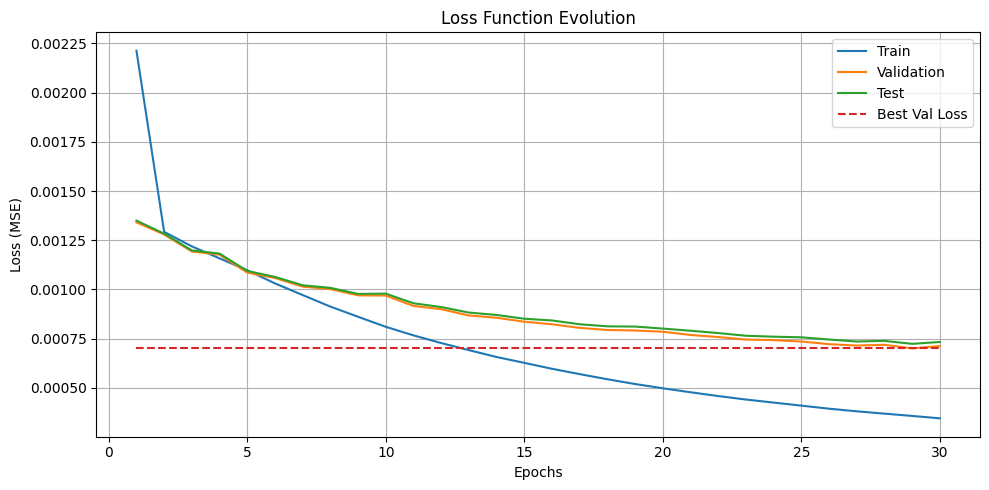


Visualization of the validation set:


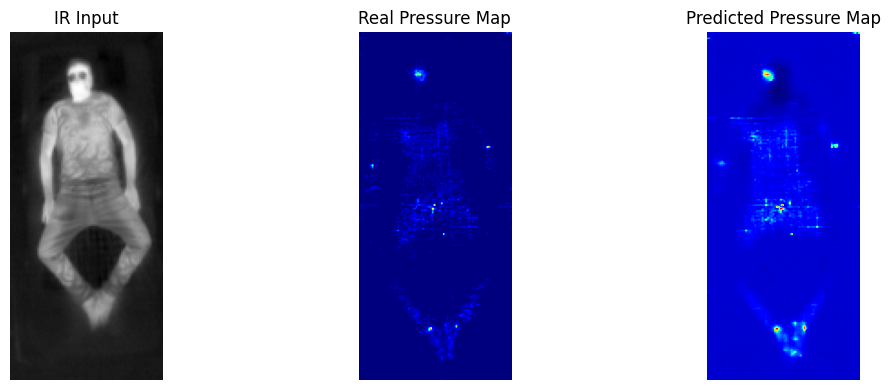

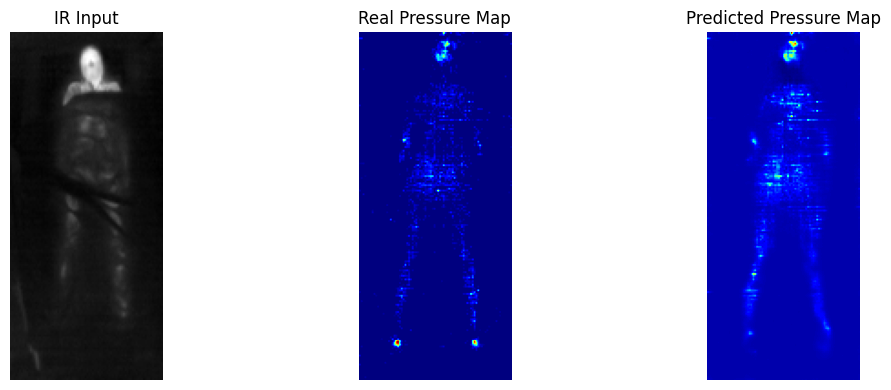

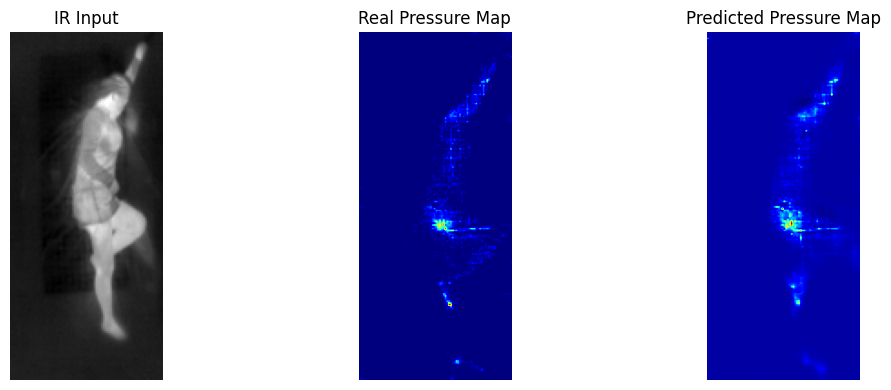

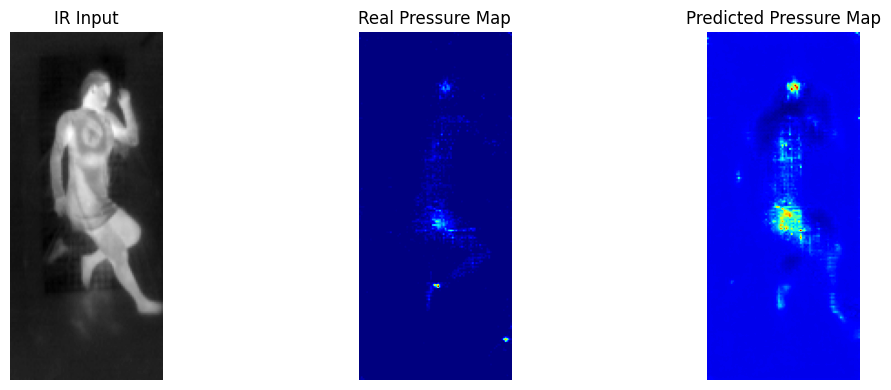

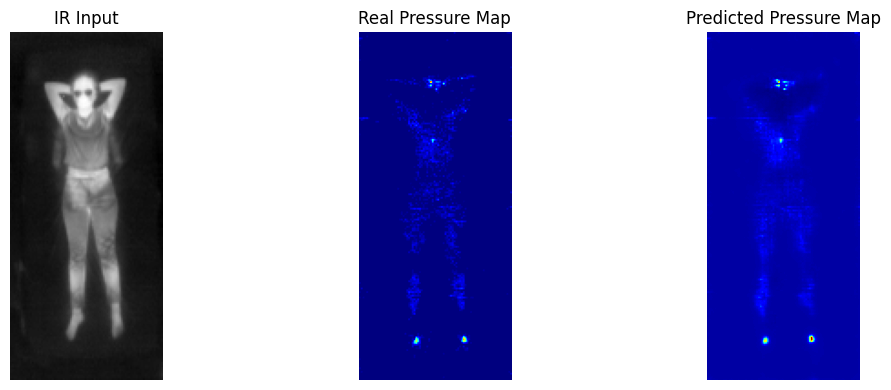

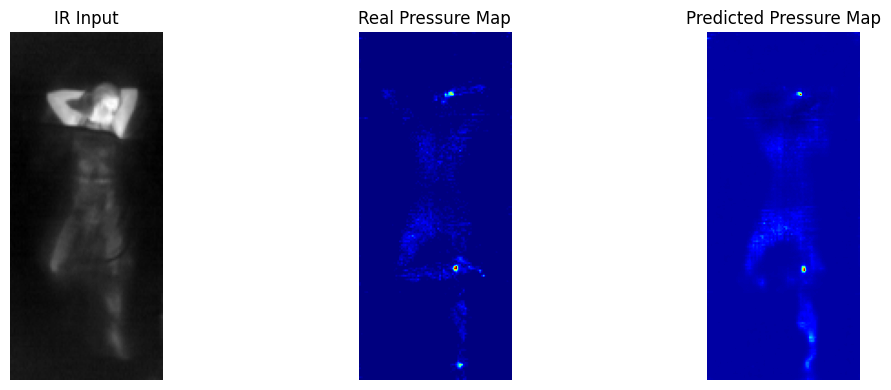

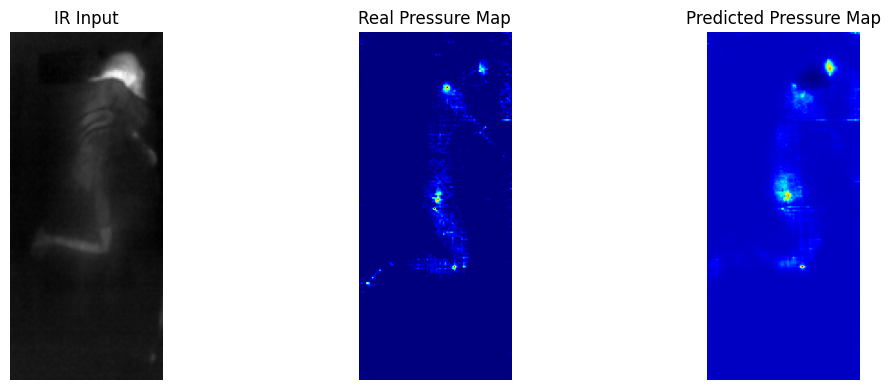

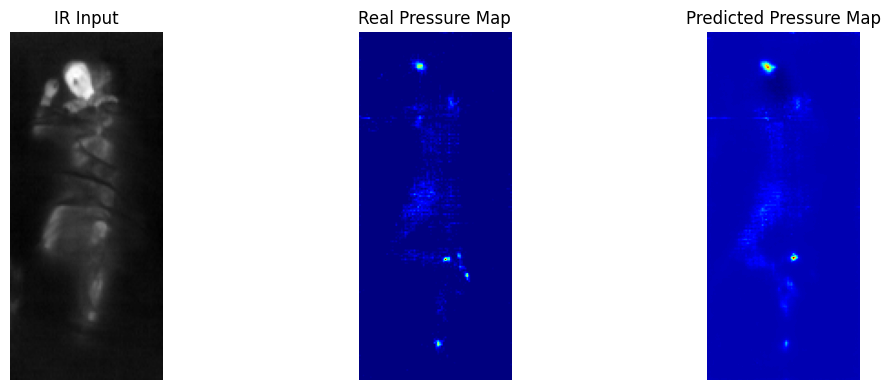


Visualization of the test set:


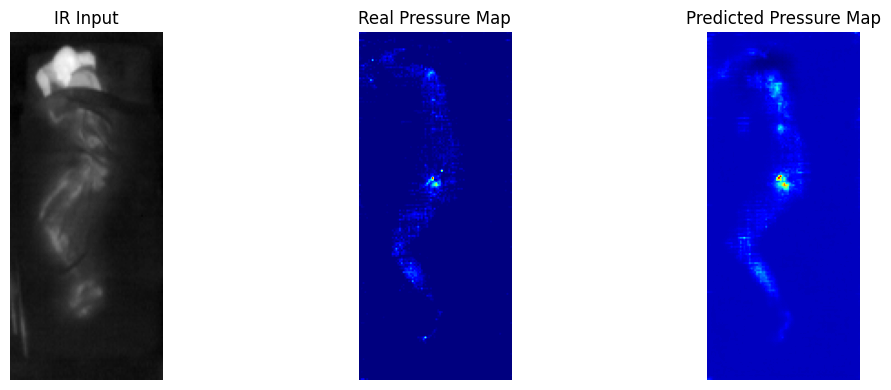

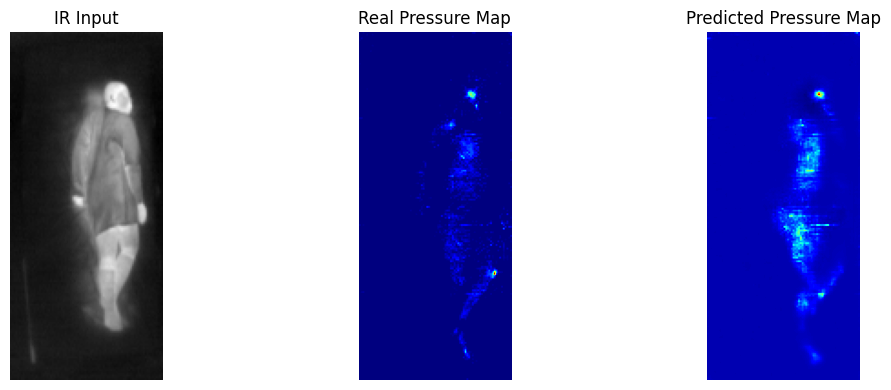

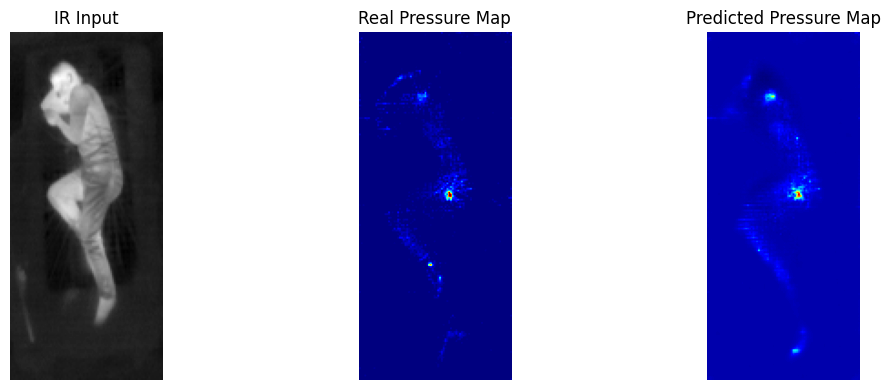

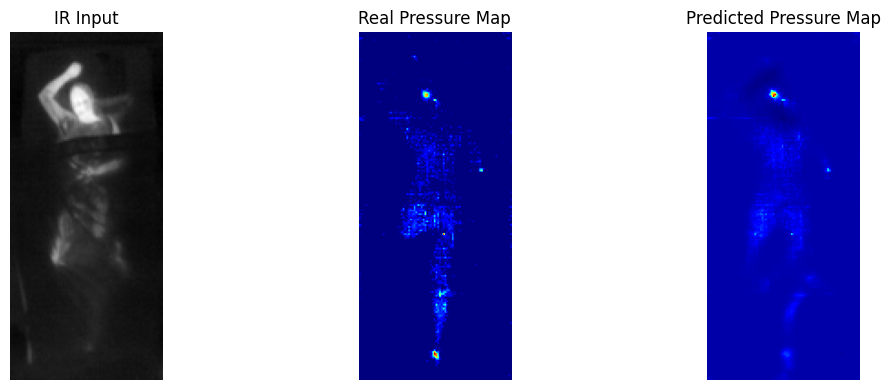

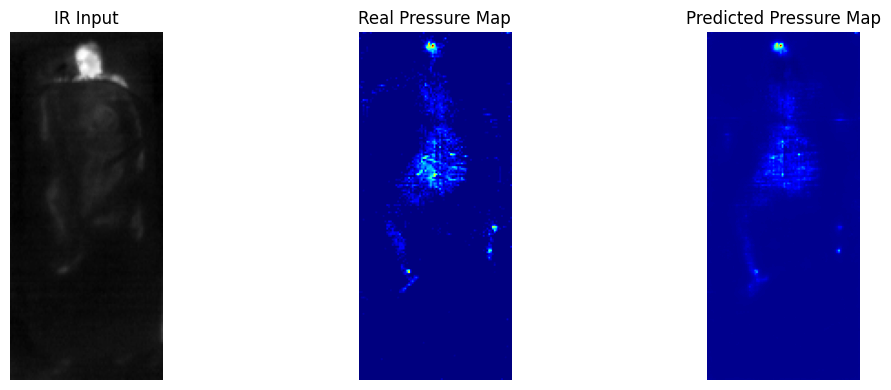

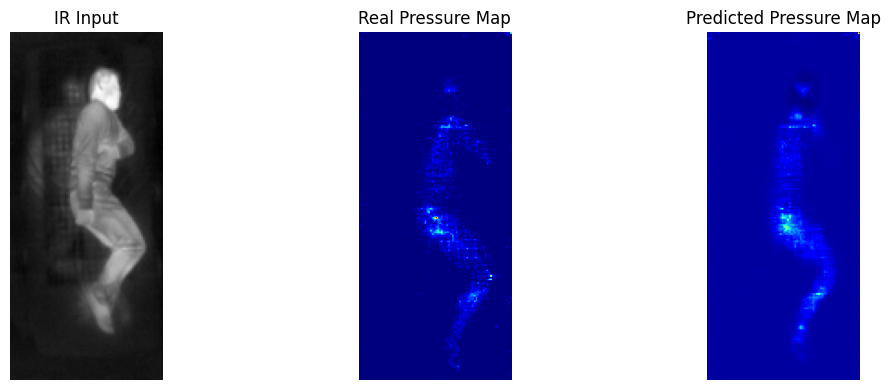

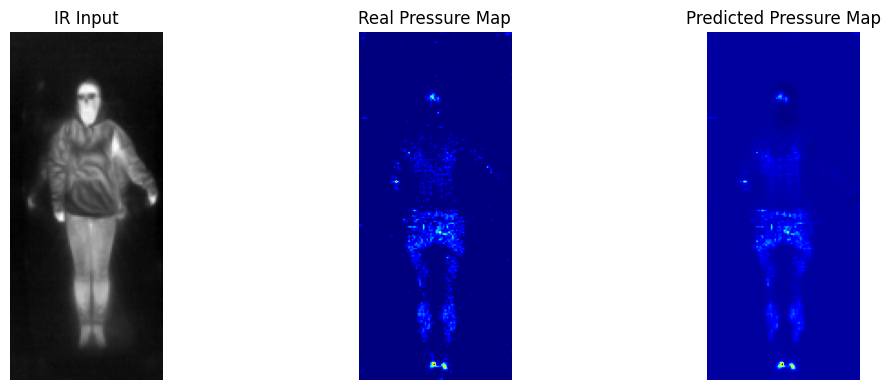

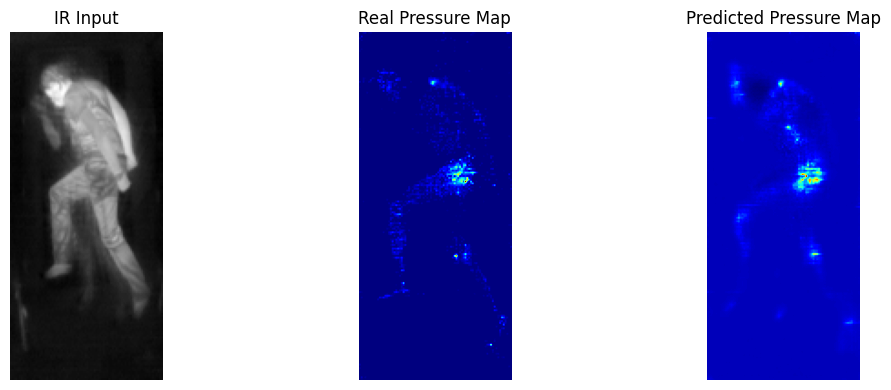


Evaluación final en Validación:
  MSE: 0.0007
  MAE: 0.0078
  R² Score: 0.5311
  Precisión (PerCS): 91.35%

Evaluación final en Test:
  MSE: 0.0007
  MAE: 0.0078
  R² Score: 0.5196
  Precisión (PerCS): 91.34%
Sample 0: Valores normalizados - min: -0.025, max: 0.961
Sample 0: Valores desnormalizados (mmHg) - min: -5.6, max: 211.4
Guardado: /mnt/DADES/home/lchachoud/Predicciones/00032/cover1/image_000001_pred.npy
Sample 1: Valores normalizados - min: -0.031, max: 0.643
Sample 1: Valores desnormalizados (mmHg) - min: -6.8, max: 141.5
Guardado: /mnt/DADES/home/lchachoud/Predicciones/00032/cover1/image_000002_pred.npy
Sample 2: Valores normalizados - min: -0.029, max: 0.894
Sample 2: Valores desnormalizados (mmHg) - min: -6.4, max: 196.6
Guardado: /mnt/DADES/home/lchachoud/Predicciones/00032/cover1/image_000003_pred.npy
Sample 3: Valores normalizados - min: -0.029, max: 0.958
Sample 3: Valores desnormalizados (mmHg) - min: -6.3, max: 210.7
Guardado: /mnt/DADES/home/lchachoud/Predicciones/0

In [13]:
if __name__ == "__main__":
    root_dir = "/mnt/DADES2/SLP/SLP/danaLab"

    def process_ir(pil_img, target_size=(84, 192)):
        width, height = pil_img.size
        left = (width - 84) / 2
        right = left + 84
        top = 0
        bottom = height
        cropped_img = pil_img.crop((left, top, right, bottom))
        resized_img = cropped_img.resize(target_size, Image.LANCZOS)
        return resized_img

    def process_pm(pil_img):
        pm_np = np.array(pil_img, dtype=np.float32)
        max_val = pm_np.max() if pm_np.max() != 0 else 1
        pm_np /= max_val
        pm_np = np.clip(pm_np, 0, 1)
        pm_np = (pm_np*255).astype(np.uint8)
        return Image.fromarray(pm_np)

    transform_ir = transforms.Compose([
        transforms.Lambda(lambda img: process_ir(img, (84, 192))),
        transforms.ToTensor()
    ])

    transform_pm = transforms.Compose([
        transforms.Lambda(lambda img: process_pm(img)),
        transforms.ToTensor()
    ])

    full_dataset = DanaLabDataset(
        root_dir=root_dir,
        conditions=['cover1', 'cover2', 'uncover'],
        transform_ir=transform_ir,
        transform_pm=transform_pm,
        show_debug=False
    )

    total_size = len(full_dataset)
    val_size = int(0.10 * total_size)
    test_size = int(0.20 * total_size)
    train_size = total_size - val_size - test_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    print(f"Total samples: {total_size}")
    print(f"Training: {train_size} | Validation: {val_size} | Test: {test_size}")

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, drop_last=True)
    test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = UNET(in_channels=1, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []
    test_losses = []

    best_val_loss = float('inf')
    patience = 3
    counter = 0
    max_epochs = 30

    print("Starting training...")
    for epoch in range(1, max_epochs + 1):
        print(f"\nEpoch [{epoch}/{max_epochs}]")
        train_loss = training(model, train_loader, optimizer, loss_fn, device)
        val_loss = validate(model, val_loader, loss_fn, device)
        test_loss = test(model, test_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"  >> Train: {train_loss:.4f} | Val: {val_loss:.4f} | Test: {test_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"\nEarly stopping: no mejora en {patience} épocas.")
                break

    print("Training completed.")

    # Plot all loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation')
    plt.plot(range(1, len(test_losses)+1), test_losses, label='Test')
    plt.plot(range(1, len(val_losses)+1), [best_val_loss]*len(val_losses), '--', label='Best Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Function Evolution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Visualization
    print("\nVisualization of the validation set:")
    test_and_show(model, val_loader, device=device, max_batches=1)

    print("\nVisualization of the test set:")
    test_and_show(model, test_loader, device=device, max_batches=1)

    # Final evaluation
    mse_val, mae_val, r2_val, percs_val = evaluate_model(model, val_loader, device)
    print("\nEvaluación final en Validación:")
    print(f"  MSE: {mse_val:.4f}")
    print(f"  MAE: {mae_val:.4f}")
    print(f"  R² Score: {r2_val:.4f}")
    print(f"  Precisión (PerCS): {percs_val*100:.2f}%")

    mse_test, mae_test, r2_test, percs_test = evaluate_model(model, test_loader, device)
    print("\nEvaluación final en Test:")
    print(f"  MSE: {mse_test:.4f}")
    print(f"  MAE: {mae_test:.4f}")
    print(f"  R² Score: {r2_test:.4f}")
    print(f"  Precisión (PerCS): {percs_test*100:.2f}%")

    # Save predictions
    output_predictions_root = "/mnt/DADES/home/lchachoud/Predicciones/"
    save_predictions(model, full_dataset, output_predictions_root, device=device)

    # Save the model
    torch.save(model.state_dict(), "modelo_UNET30_entrenado.pth")


After training the U-Net model with the infrared images and the pressure maps, I evaluated its performance on the training, validation, and test sets. I applied early stopping to prevent overfitting, and the loss graph shows how the training loss decreases steadily, while the validation loss drops initially and then stabilizes. This indicates that the model stopped improving in terms of generalization after a certain point (around 15–20 epochs). I also added horizontal lines to show both the best validation loss achieved and the final loss obtained on the test set, to provide a clear reference when comparing the curves.

Regarding the numerical results, the model achieved an MSE of 0.0008 on both the validation and test sets, which is a quite low average error. The MAE was also very low: 0.0085 on validation and 0.0086 on test. This suggests that the predictions are quite close to the real values, at least in terms of average deviation per pixel.

The R² Score was approximately 0.48 on both sets. This value indicates that the model is able to capture part of the real information contained in the pressure maps, but not all of it. The closer this value is to 1, the better. While this score is not particularly high, it does show that the model has learned something useful. The moderate R² may be due to high variability between patients or postures, which makes it more difficult for the model to predict with full accuracy.

On the other hand, the PerCS accuracy was very good: 90.73% on validation and 90.64% on test. This means that over 90% of the predicted pixels have an error below 2.5% of the actual maximum value, which I consider quite positive for a first version of the model.

In summary, I believe the model has learned to make reasonably coherent predictions. Although there is still room for improvement in terms of explaining the full variation in the pressure maps, the errors are low and the pixel-wise accuracy is high, so I consider this a strong initial result.

### CALCULATE MASS AND WEIGHTS:

The `calculate_mass_sensor` function estimates the total mass applied to a pressure sensor based on a pressure map in mmHg. It first converts the values to Pascals, then calculates the force on each pixel by multiplying the pressure by the pixel area, and finally sums all the forces to obtain the total force. Using the formula $m = F / g$, it converts that force into mass in kilograms. The function returns both the mass and the total force, and it is useful for estimating the weight applied to a pressure-sensitive surface, such as the mattress.

In [ ]:
def calculate_mass_sensor(sensor_data, pixel_area_m2, conversion_factor=133.322, g=9.81):
    """
    Calculates the total mass applied on a pressure sensor.
    
    Parameters:
      sensor_data (np.array): 2D array with sensor readings in mmHg.
      pixel_area_m2 (float): Area of each pixel in square meters.
      conversion_factor (float): Conversion factor from mmHg to Pascals (default is 133.322).
      g (float): Gravitational acceleration in m/s² (default is 9.81).
      
    Returns:
      tuple: (mass, F_total)
        mass (float): Total mass in kg.
        F_total (float): Total force in Newtons.
    """
    # Convert the pressure from mmHg to Pascals
    # 1 mmHg = 133.322 Pa
    pressure_pa = sensor_data * conversion_factor

    # Calculate the force for each pixel: F = P * A
    # where P is the pressure in Pascals and A is the area in m²
    F_pixels = pressure_pa * pixel_area_m2

    # Sum the forces to get the total force
    F_total = np.sum(F_pixels)

    # Calculate the mass: m = F_total / g
    mass = F_total / g

    return mass, F_total

In [ ]:
"""
if __name__ == "__main__":

    # Each pixel has an area of 1.03226 cm² = 1.03226e-4 m²
    pixel_area = 1.03226e-4

    final_text = ""
    for patient in sorted(os.listdir(output_predictions_root)):
        patient_dir = os.path.join(output_predictions_root, patient)
        if not os.path.isdir(patient_dir):
            continue
        line = f"Paciente: {patient}\n"
        print(line, end='')
        final_text += line

        # Iterate through each condition (cover1, cover2, uncover, etc.)
        for condition in sorted(os.listdir(patient_dir)):
            condition_dir = os.path.join(patient_dir, condition)
            if not os.path.isdir(condition_dir):
                continue
            line = f"  Condición: {condition}\n"
            print(line, end='')
            final_text += line
            
            # Obtain the list of .npy files
            npy_files = [f for f in os.listdir(condition_dir) if f.endswith('.npy')]
            if not npy_files:
                line = f"    -> No se encontraron archivos .npy\n"
                print(line, end='')
                final_text += line
                continue
            
            # Order the files and select the first one
            npy_files.sort()
            first_file = npy_files[0]
            file_path = os.path.join(condition_dir, first_file)
            
            # Calculate the mass
            sensor_data = np.load(file_path)
            masa, F_total = calculate_mass_sensor(sensor_data, pixel_area)
            
            line = f"Primer archivo: {first_file} | Fuerza total: {F_total:.2f} N, Masa: {masa:.2f} kg\n"
            print(line, end='')
            final_text += line
    
    # Save the results in a text file
    output_txt_path = os.path.join(output_predictions_root, "resultados.txt")
    with open(output_txt_path, "w") as f:
        f.write(final_text)
    print(f"\nResultados guardados en: {output_txt_path}")
    print("Fin del script.")
"""

PREDICTED WEIGTHS:

In [ ]:
#Results in txt file in order to compare
resultados = "/mnt/DADES/home/lchachoud/Predicciones/resultados.txt"
for line in open(resultados, 'r'):
    print(line.strip())

We can observe that the weights predicted by the model are not very similar to the ground truth. This could be due to several reasons. First, the model does not predict the pressure maps with perfect accuracy. Although it achieves around 90% precision, which is a good result—this margin of error can accumulate and affect the final mass calculation, since small differences in pressure can lead to significant deviations when integrated over the entire surface.

Additionally, the normalization applied was the same for all cases, assuming a maximum value of 220 mmHg. However, in reality, this maximum can vary significantly between patients or situations. Using 220 as a fixed value (based on an approximate average) may introduce a systematic error during denormalization, which directly affects the mass estimation results.

It’s also possible that not all pixels in the pressure map contribute equally. Some may correspond to areas of the body where there is more or less actual pressure, or may be more affected by movement, posture, or sensor noise. All of this can make the total force calculation less accurate, and as a result, the estimated weight may not match the actual one.